# Fig. 4: Breakdown of the impacts of various top datasets on the 2-dimensional subspace of the four-fermion operators

As of June 2021, the plot generated does not match the journal version of our paper.  
Missing dependencies in $t\bar{t}W$ on $C_{tq}^8$ & $C_{tG}$ were added that modify the individual regions for "$t\bar{t}V$ Run 1" & "$t\bar{t}V+t\bar{t}H$ Run 2".  
(fitmaker commit hash 7263a6a8102d81f478131e0d3a8ee27872a52018)  
Thanks to Maria Moreno Llacer for pointing those out!

In [1]:
import sys
from collections import OrderedDict
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator
from matplotlib.offsetbox import AnchoredText
from matplotlib import rcParams
# colours
green, lightblue, orange, yellow, blue, red, purple, pink, darkblue, brown = (
  "#009e73", "#56b4e9", "#e69f00", "#f0e442", "#0072b2", "#e51e10", "#9400d3", "#f684b6", "#01579B", "#8D6E63"
)
lightgrey, grey, darkgrey = '#CCD7DB','#96ABB3','#586D75'

sys.path.append('../')
from fitmaker.fitlib.fitter import FitterChiSquare
from fitmaker.fitlib.fitter import FitterAnalyticalChiSquare
from fitmaker.fitlib.observable import ObsGroup, Obs

In [2]:
from util import coeffs_tex as otex, linear_fit_df

### Load data

In [3]:
from data import EWPO_data

from data import top_data_new

from data import (top_ttbar_Run1, top_ttbar_Run2, top_ttbar_Asy, top_ttbar_whel, 
                  top_singletop_Run1, top_singletop_Run2, 
                  top_ttV_Run1, top_ttV_Run2, top_ttX_Run2)

### Import theory model

In [4]:
from models import SMEFT_top

Order of coefficients

In [5]:
coeffs_top = [ 
  'CtH', 'CtG', 'CG', 
  'CHQ1', 'CHQ3', 'CHt', 
  'CtB', 'CtW', 
  'CQq31', 'CQq38', 'CQq18', 'CQu8', 'CQd8', 'Ctq8', 'Ctu8', 'Ctd8'
]

### Make sub-fits to individual datasets & combination

In [6]:
# Individual datasets & labels
datasets_finer = [
  (EWPO_data, r'$EWPO$'),
  (top_ttbar_whel, r'$W$ helicity'),
  (top_singletop_Run1, r'single top Run 1' ),
  (top_singletop_Run2, r'single top Run 2' ),
  (top_ttV_Run1, r'$t\bar{t}V$ Run 1'),
  (top_ttX_Run2, r'$t\bar{t}V+t\bar{t}H$ Run 2'),
  (top_ttbar_Run1, r'$t\bar{t}$ Run 1' ),
  (top_ttbar_Run2, r'$t\bar{t}$ Run 2' ),
  (top_ttbar_Asy, r'$t\bar{t}$ asymmetries')
]

# Make fit & fit DataFrame for each one
fits_finer, dfs_finer = OrderedDict(), OrderedDict()
for data, obs in datasets_finer:

    # make sure it is an ObsGroup instance
    if isinstance(data,Obs):
        newdata = ObsGroup()
        newdata.add_obs(data)
        data=newdata
    
    # produce fit & df
    fits_finer[obs], dfs_finer[obs] = linear_fit_df(data, SMEFT_top, coeffs_top, Lambda=1000.)
    dfs_finer[obs].set_index('Coefficient', inplace=True)
    # Add pull information to df
    dfs_finer[obs]['individual pull'] =  dfs_finer[obs]['individual best-fit']/dfs_finer[obs]['individual s.d.']
    dfs_finer[obs]['marginalised pull'] =  dfs_finer[obs]['marginalised best-fit']/dfs_finer[obs]['marginalised s.d.']

# combine individual datasets & make a fit & df
all_top_data = ObsGroup({'observable_group_name':"all_top_data", 'description':"all top data"})
all_top_data.add_obs(*[d[0] for d in datasets_finer])

fit_all, df_all = linear_fit_df(all_top_data, SMEFT_top, coeffs_top, Lambda=1000.)

### Plot breakdown of 2D confidence regions

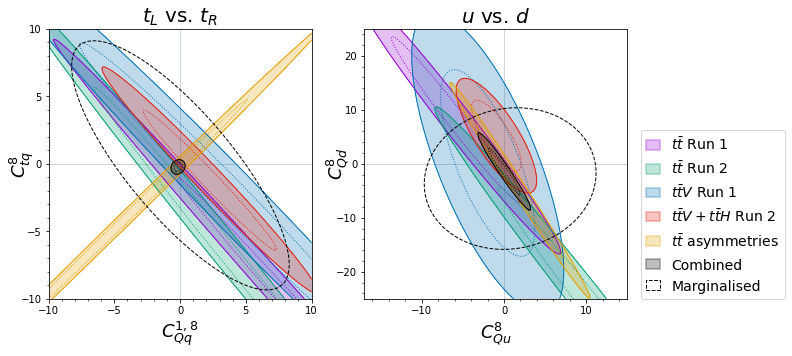

In [7]:
rcParams.update({
  'figure.subplot.left': 0.13,
  'figure.subplot.bottom': 0.15,
  'figure.subplot.right': 0.8,
  'figure.subplot.top': 0.9,
})

# Which pairs of coefficients to plot
pairs = (['CQq18', 'Ctq8'], ['CQu8','CQd8'])

datasets = [
  r'$t\bar{t}$ Run 1', r'$t\bar{t}$ Run 2',
  r'$t\bar{t}V$ Run 1', r'$t\bar{t}V+t\bar{t}H$ Run 2',
  r'$t\bar{t}$ asymmetries'
]

fig, axs = plt.subplots(1,2,figsize=(12,5))

# x, y limits of axes
lims1 =[( -10,10, -10,10), (-17,15, -25,25)]

# x, y limits over which to determine combined contour
lims2 =[( -3,3,-3,3),(-10,10,-17,6)]

# major & minor ticks
maj_mins = [(5,1), (10,2)]

for pair, ax, lim1, lim2, maj_min  in zip(pairs, axs, lims1, lims2, maj_mins):
    xmin, xmax, ymin, ymax = lim1 # boundaries of grid
    npoints = 200 # granularity of grid
    corder = (purple, green, blue, red, orange) # colours

    # find contours for each individual dataset
    handles, labels = [], []
    for i, dataset in enumerate(datasets):
        # vectorised 2D delta-chi^2 function from fit
        chi2func = np.vectorize( 
          fits_finer[dataset].chisquare_function(*pair, delta_chisquare=True) 
        )
        
        # construct x,y grid of points & evaluate delta-chi^2
        xval, yval = np.linspace(xmin, xmax ,num=npoints),  np.linspace(ymin, ymax,num=npoints)
        xgrid, ygrid = np.meshgrid(xval, yval)
        dchi2 = chi2func(xgrid,ygrid)
        
        # draw contours for 1 & 2 sigma
        # lines
        ax.contour(
          xgrid, ygrid, dchi2, 
          levels=[2.30,5.99], 
          labels = dataset, 
          colors = corder[i], 
          linestyles=['dotted', 'solid'], 
          linewidths=1.
        )
        # filled
        ax.contourf(
          xgrid, ygrid, dchi2, 
          levels=[0.,5.99], 
          labels = dataset, 
          colors = corder[i], 
          alpha=0.25, 
          linewidths=1
        )
        # legend items
        handles.append(plt.Rectangle((0,0),1,1,fc=corder[i], alpha=0.25, edgecolor=corder[i], linewidth=2))
        labels.append(dataset)
        
    # find contours for combined dataset
    xmin2, xmax2, ymin2, ymax2 = lim2
    npoints = 50
    
    # individual
    chi2func = np.vectorize(
      fit_all.chisquare_function(*pair, delta_chisquare=True)
    )
    
    xval, yval = np.linspace(xmin2, xmax2 ,num=npoints),  np.linspace(ymin2, ymax2,num=npoints)
    xgrid, ygrid = np.meshgrid(xval, yval)
    dchi2 = chi2func(xgrid,ygrid)
    
    ax.contour(
      xgrid, ygrid, dchi2, 
      levels=[2.30,5.99], 
      label = dataset, 
      colors = 'k', 
      linestyles=['dotted', 'solid'], 
      linewidths=1., 
      zorder=10
    )
    
    ax.contourf(
      xgrid, ygrid, dchi2, 
      levels=[0.,5.99], 
      label = dataset, 
      colors = 'k', 
      alpha=0.25, 
      linewidths=1, 
      zorder=10
    )
    
    handles.append(plt.Rectangle((0,0),1,1,fc='k', alpha=0.25, edgecolor='k', linewidth=2))
    labels.append('Combined')
    
    # marginalised
    chi2func = np.vectorize(
      fit_all.chisquare_function(*pair, delta_chisquare=True, marginalise=True)
    )
    
    xval, yval = np.linspace(xmin, xmax ,num=npoints),  np.linspace(ymin, ymax,num=npoints)
    xgrid, ygrid = np.meshgrid(xval, yval)
    dchi2 = chi2func(xgrid,ygrid)
    
    ax.contour(
      xgrid, ygrid, dchi2, 
      levels=[5.99], 
      label = dataset, 
      colors = 'k', 
      linestyles=['dashed'], 
      linewidths=1., 
      zorder=10
    )
    
    handles.append(plt.Rectangle((0,0),1,1,fc='none', alpha=1, edgecolor='k', linewidth=1, linestyle='dashed'))
    labels.append('Marginalised')
    
    # plot parameters
    ax.plot([xmin,xmax],[0.,0.],c=lightgrey,lw=1,ls='solid',zorder=0)
    ax.plot([0.,0.],[ymin,ymax],c=lightgrey,lw=1,ls='solid',zorder=0)
    
    ax.set_xlabel(r'${}$'.format(otex[pair[0]]), fontsize=18)
    ax.set_ylabel(r'${}$'.format(otex[pair[1]]), fontsize=18, labelpad=-15)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.xaxis.set_major_locator(MultipleLocator(maj_min[0]))
    ax.yaxis.set_major_locator(MultipleLocator(maj_min[0]))
    ax.xaxis.set_minor_locator(MultipleLocator(maj_min[1]))
    ax.yaxis.set_minor_locator(MultipleLocator(maj_min[1]))
    
axs[0].set_title(r'$t_L$ vs. $t_R$', fontsize=20)
axs[1].set_title(r'$u$ vs. $d$', fontsize=20)

axs[1].legend(handles,labels,handlelength=1,fontsize=14,loc=(1.05,0))
plt.savefig('Fig4/top_breakdown_spin_vs_isospin.pdf')

### Journal version of the plot

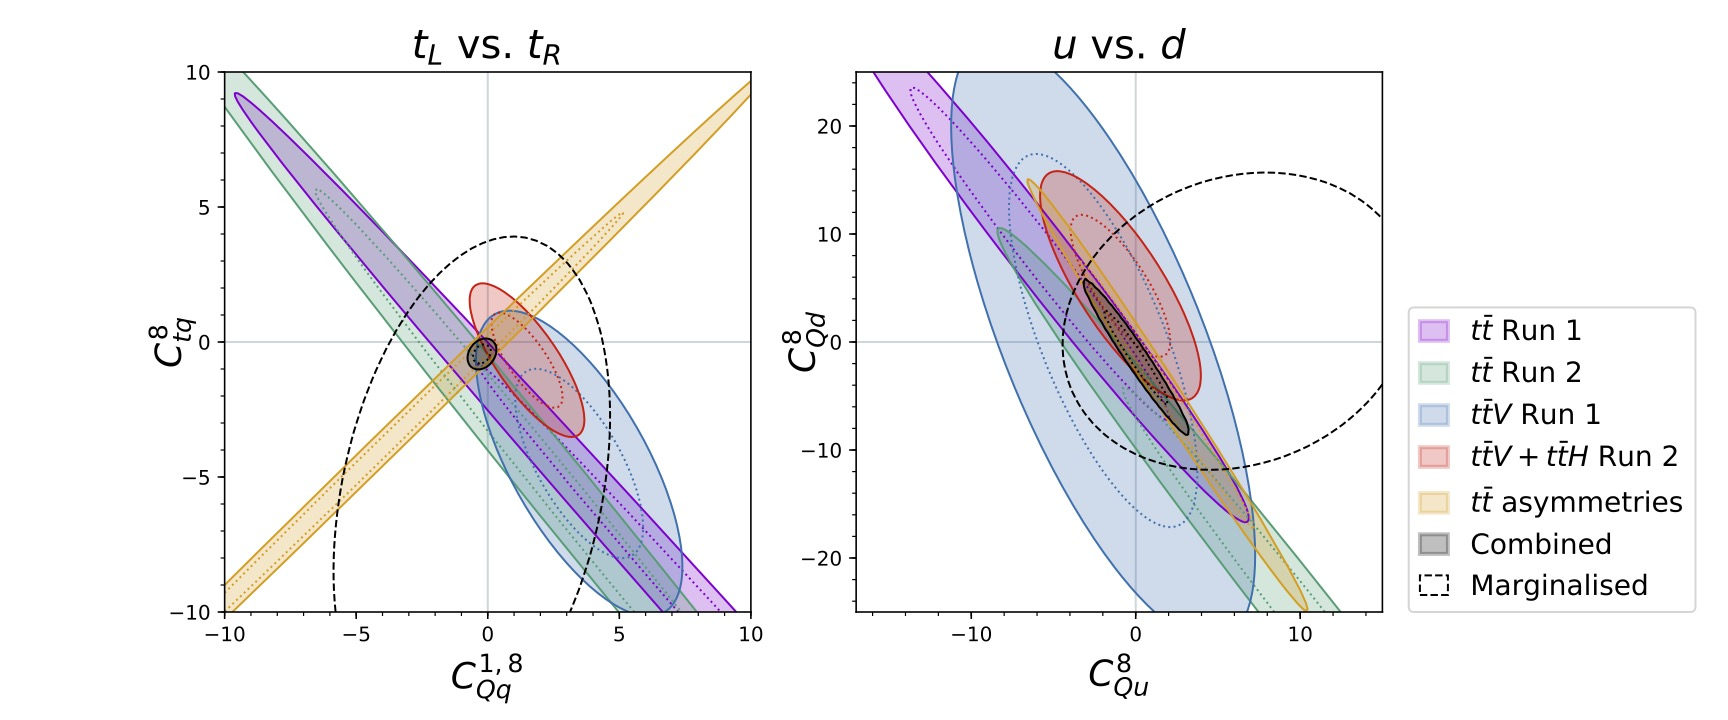

In [8]:
from IPython import display
display.Image("Fig4/top_breakdown_spin_vs_isospin_JOURNAL.jpg")